# Imports

In [ ]:
!pip install transformers lime shap sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.5 MB/s 
     |████████████████████████████████| 275 kB 23.1 MB/s 
     |████████████████████████████████| 564 kB 61.5 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.5 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=798950c569dc6ffaec8c08a02b530f3873dc7279f23739f758acf896e7f842d0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import os.path
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import spacy
import sys
from sklearn.feature_extraction.text import CountVectorizer
import time
import shap
import pandas as pd


In [ ]:
## Use the BertScore from the repo

from drive.MyDrive.data.bert_score.scorer import BERTScorer

# Eval


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr
import numpy as np

def validate_word_level_data(gold_explanations, model_explanations):
    valid_gold, valid_model = [], []
    for gold_expl, model_expl in zip(gold_explanations, model_explanations):
        if sum(gold_expl) == 0 or sum(gold_expl) == len(gold_expl):
            continue
        else:
            valid_gold.append(gold_expl)
            valid_model.append(model_expl)
    return valid_gold, valid_model

def compute_auc_score(gold_explanations, model_explanations):
    res = 0
    for i in range(len(gold_explanations)):
        res += roc_auc_score(gold_explanations[i], model_explanations[i])
    return res / len(gold_explanations)

def compute_ap_score(gold_explanations, model_explanations):
    res = 0
    for i in range(len(gold_explanations)):
        res += average_precision_score(gold_explanations[i], model_explanations[i])
    return res / len(gold_explanations)


def compute_rec_topk(gold_explanations, model_explanations):
    res = 0
    for i in range(len(gold_explanations)):
        idxs = np.argsort(model_explanations[i])[::-1][:sum(gold_explanations[i])]
        res += len([idx for idx in idxs if gold_explanations[i][idx] == 1])/sum(gold_explanations[i])
    return res / len(gold_explanations)


def evaluate_word_level(gold_explanations, model_explanations):
    gold_explanations, model_explanations = validate_word_level_data(gold_explanations, model_explanations)
    auc_score = compute_auc_score(gold_explanations, model_explanations)
    ap_score = compute_ap_score(gold_explanations, model_explanations)
    rec_topk = compute_rec_topk(gold_explanations, model_explanations)
    print('AUC score: {:.3f}'.format(auc_score))
    print('AP score: {:.3f}'.format(ap_score))
    print('Recall at top-K: {:.3f}'.format(rec_topk))
    return auc_score, ap_score, rec_topk


def evaluate_sentence_level(gold_scores, model_scores):
    corr = pearsonr(gold_scores, model_scores)[0]
    #print('Pearson correlation: {:.3f}'.format(corr))
    return corr

In [ ]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# Iterative

In [ ]:
from lime.lime_text import LimeTextExplainer
import tqdm
import numpy as np
import json
from scipy.stats.mstats import gmean
from numpy import mean
import argparse


model_type = 'joeddav/xlm-roberta-large-xnli'
num_layers = 16
idf_sents = 0
scorer = BERTScorer(model_type=model_type, batch_size=64, num_layers=num_layers)


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#data is in the repo

SRC_LANG = 'et'
TGT_LANG = 'en'
path = "drive/MyDrive/"
SPLIT = 'test21'
data_dir =  path + f'data/{SPLIT}/{SRC_LANG}-{TGT_LANG}-{SPLIT}'
src = [s.strip() for s in open(f'{data_dir}/{SPLIT}.src').readlines()]
tgt = [s.strip() for s in open(f'{data_dir}/{SPLIT}.mt').readlines()]
wor = [list(map(int, s.strip().split())) for s in open(f'{data_dir}/{SPLIT}.tgt-tags').readlines()]
sen = [float(s.strip()) for s in open(f'{data_dir}/{SPLIT}.da').readlines()]
assert len(src) == len(tgt) == len(wor) == len(sen)
dataset = {'src': src, 'tgt': tgt, 'word_labels': wor, 'sent_labels': sen}


In [ ]:
bertscores ,hyp_explanations, src_explanations = scorer.score(dataset['tgt'], dataset['src'])

In [ ]:
with open(path+f"data/explainability/limeresults_{SRC_LANG+TGT_LANG}_16_100.json") as f:
  results = json.load(f)

In [ ]:
def gen_mean(vals, p):
    p = float(p)
    return np.power(
        np.mean(
            np.power(
                np.array(vals, dtype=complex),
                p),
            axis=0),
        1 / p
    ).real

In [ ]:
dataframe = pd.DataFrame(columns=["src","tgt","p","w","corr"])
for i in range (-100,101,1):
  if i == 0:
    continue 
  p = i/10;
  sentence_scores = [ gen_mean([w[1] for w in s['1']],p) for s in results]
  print(f"V: {p}")
  sentence_scores = np.nan_to_num(sentence_scores,0)
  print("BertScore")
  evaluate_sentence_level(sen,bertscores[2])
  for i in range(11):
      cumscores =  np.add(bertscores[2]*i/10,sentence_scores*(1-i/10))
      print(f"I: {i}: ")
      value = evaluate_sentence_level(sen,cumscores)
      dataframe = pd.concat([dataframe,pd.DataFrame({"src":SRC_LANG, "tgt": TGT_LANG, "p":p, "w":i/10, "corr": value},index=[0])])

In [ ]:
def collapse_list(l):
  # Collapses the list of tokens and attributions scores, if subword tokenization denotes spaces with '▁' or 'Ġ'
  # Word-level scores of tokens that belong to the same word are averaged.
  # There could be rare cases where subword tokens contain a space in the middle instead of the beginning of a word.
  # In such a case the word level score might be inferred by the aligning function that is used during evaluation
  # I did not notice such a case in the shared task

  words = [l[0][1][1:]]   # A list of tokens. The first letter of the first token is removed
  scores = [l[0][0]]      # A list of scores per token, initialised with the first one
  inb = 1                 # A counter that indicates over how many elements subwords should be averaged
  for x in range(1, len(l)):
      if l[x][1][0] != '▁' and l[x][1][0] != 'Ġ':  # If words do not start with a spacem I collapse them with the previous
          words[-1] += l[x][1]  # Appending the last string
          if scores[-1] > l[x][0]:
            scores[-1] = l[x][0] # Adding to the last score
          inb += 1              # Increasing the number of scores that are averaged
          # if len(l) - 1 == x:
          #     scores[-1] /= inb # If we have reached the last element, we average
      else:
          #scores[-1] /= inb           # Average with the current inb counter
          inb = 1                     # Reset the counter
          words.append(l[x][1][1:])   # Add a new word and remove the trailing space
          scores.append(l[x][0])      # Add a new score
  return list(zip(words, scores))

  

In [ ]:
hyp_explanations = [collapse_list(e[1:-1]) for e in hyp_explanations]
src_explanations = [collapse_list(e[1:-1]) for e in src_explanations]

In [ ]:
hyp_expl = [ [ s[1]*-1 for s in src] for src in hyp_explanations]
src_expl = [ [ s[1]*-1 for s in src] for src in src_explanations]

In [ ]:
# First Iteration

dataframe = pd.DataFrame(columns=["src","tgt","p","w","corr"])

for i in range (-100,101,1):
  if i == 0:
    continue 
  p = i/10;
  sentence_scores = [ gen_mean([w[1] for w in s['1']],p) for s in results]
  sentence_scores = np.nan_to_num(sentence_scores,0)
  for i in range(11):
      cumscores =  np.add(bertscores[2]*i/10,sentence_scores*(1-i/10))
      print(f"I: {i}: ")
      value = evaluate_sentence_level(sen,cumscores)
      dataframe = pd.concat([dataframe,pd.DataFrame({"src":SRC_LANG, "tgt": TGT_LANG, "p":p, "w":i/10, "corr": value},index=[0])])

In [ ]:
## 2nd Iteration

best_p = -4.1

best_w = 0.4
sentence_scores = [ gen_mean([w[1] for w in s['1']],best_p) for s in results]
sentence_scores = np.nan_to_num(sentence_scores,0)
cumscores =  np.add(bertscores[2]*best_w,sentence_scores*(1-best_w))


def erasure(hypscore, srcscore, limescores,score):
  era = []
  ls = [ s[1] for s in limescores]
  for i in range(len(hypscore)):
    erased_bscore = hypscore[0:i] + hypscore[i+1:]
    precision = np.mean(erased_bscore)
    recall = np.mean(srcscore)
    f1 = 2 * precision * recall / (precision + recall)
    erased_limescore = ls[0:i] + ls[i+1:]
    limescore = gen_mean(erased_limescore, best_p)
    limescore = np.nan_to_num(limescore,0)
    erasure_score = f1*best_w + limescore*(1-best_w)
    era.append(float(score-erasure_score))
  return era

erasure_scores = []
for i in range(len(hyp_expl)):
  erasure_scores.append(erasure(hyp_expl[i],src_expl[i],results[i]['1'], cumscores[i]))

dataframe = pd.DataFrame(columns=["src","tgt","p","w","corr"])
for i in range (-100,101,1):
  if i == 0:
    continue 
  p = i/10;
  iter2_scores = [ gen_mean(s,p) for s in erasure_scores]
  iter2_scores = np.nan_to_num(iter2_scores,0)
  evaluate_sentence_level(sen,bertscores[2])
  for i in range(11):
      cumscores =  np.add(cumscores[2]*i/10,iter2_scores*(1-i/10))
      value = evaluate_sentence_level(sen,cumscores)
      dataframe = pd.concat([dataframe,pd.DataFrame({"src":SRC_LANG, "tgt": TGT_LANG, "p":p, "w":i/10, "corr": value},index=[0])])

In [ ]:
dataframe

,index,src,tgt,p,w,corr
0,0,et,en,-10.0,0.0,0.703152
1,0,et,en,-10.0,0.1,0.703152
2,0,et,en,-10.0,0.2,0.703152
3,0,et,en,-10.0,0.3,0.703152
4,0,et,en,-10.0,0.4,0.703152
...,...,...,...,...,...,...
2195,0,et,en,10.0,0.6,0.703127
2196,0,et,en,10.0,0.7,0.703127
2197,0,et,en,10.0,0.8,0.703127
2198,0,et,en,10.0,0.9,0.703127


In [ ]:
dataframe = dataframe.reset_index()

In [ ]:
dataframe["corr"].max()

0.7031516023669899

In [ ]:
dataframe["corr"].idxmax()

1

In [ ]:
dataframe.iloc[dataframe["corr"].idxmax()]

index           0
src            et
tgt            en
p           -10.0
w             0.1
corr     0.703152
Name: 1, dtype: object

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

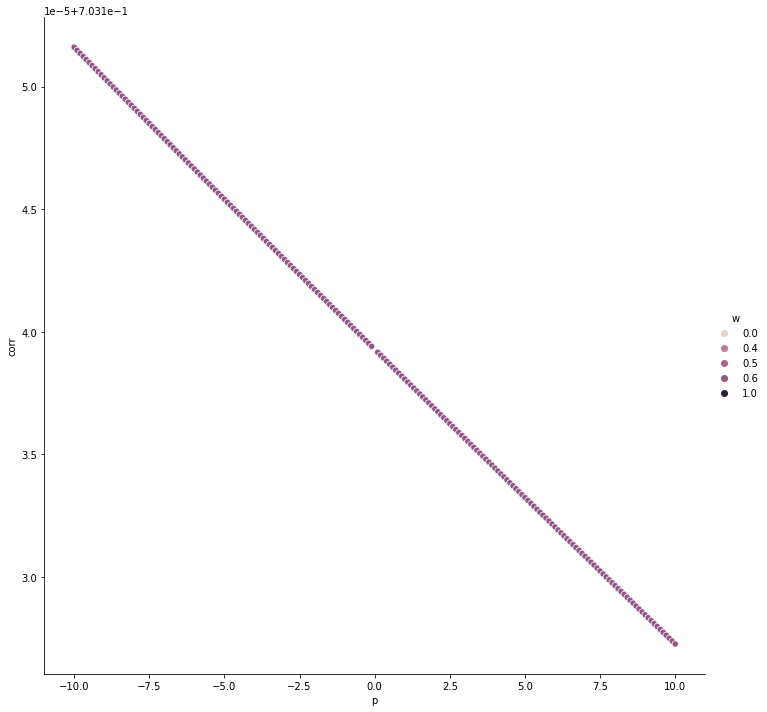

In [ ]:
sns.relplot(x="p", y="corr",hue="w",height=10, data=dataframe.query('w==0|w==0.4 |w==0.5| w==0.6 | w==1'));

In [ ]:
all_data = pd.concat([all_data,dataframe])

In [ ]:
all_data.reset_index().to_pickle("first_iter_eval4nlp.pkl")

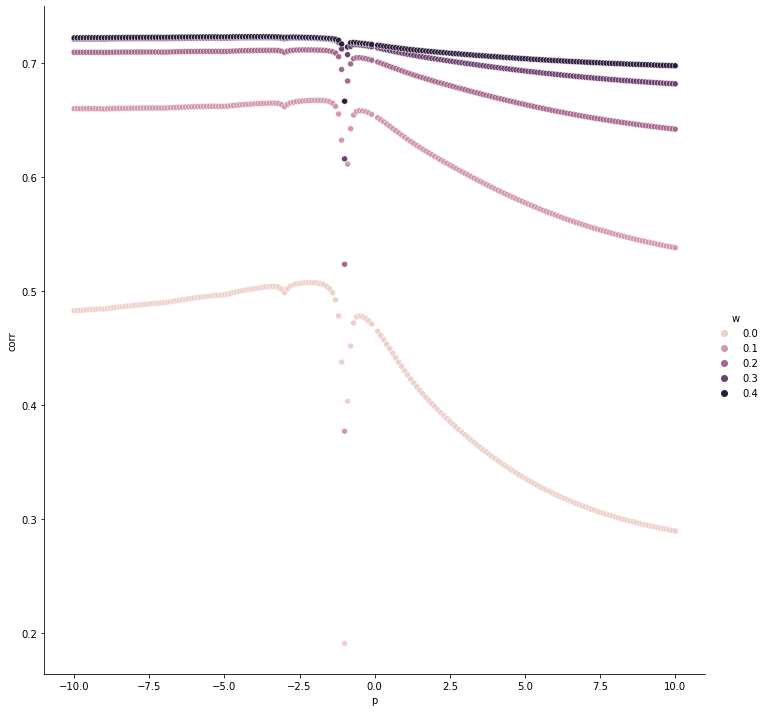

In [ ]:
sns.relplot(x="p", y="corr",hue="w",height=10, data=dataframe[dataframe.w<=0.4]);

In [ ]:
explainer = LimeTextExplainer(class_names=['score', 'score'], bow=False, split_expression = ' ')

def explain_instance(explainer, text_a, text_b):
    def predict_proba(texts):
        src = [text_a] * len(texts)
        tgt = [text_b] * len(texts)
        scores, _,_= scorer.score(tgt,texts)
        preds = np.array(scores[2]) 
        results = np.vstack((preds, preds)).T
        return results

    #predictions, raw_outputs = model.predict([[text_a, text_b]])
    exp = explainer.explain_instance(text_a, predict_proba, num_features=len(text_b.split()), labels=(1, ),num_samples=100)
    return exp.as_map()

results = []
for idx in tqdm.tqdm(range(len(dataset['src']))):
  expl = explain_instance(explainer, dataset['src'][idx], dataset['tgt'][idx])
  results.append(expl)

bertscores , _,_ = scorer.score(dataset['tgt'], dataset['src'])

with open(f"limeresults_{SRC_LANG+TGT_LANG}_16_src.json", 'w') as f:
  json.dump(results, f,cls=NpEncoder)

try:
    sentence_scores = [ gmean([w[1] for w in s[1]]) for s in results]
except KeyError:
    sentence_scores = [ gmean([w[1] for w in s['1']]) for s in results]
sentence_scores = np.nan_to_num(sentence_scores,0)
print("BertScore")
evaluate_sentence_level(sen,bertscores[2])
print(f"Score First Sentence : {bertscores[2][0]}")
print("Iterative")
for i in range(11):
    cumscores =  np.add(bertscores[2]*i/10,sentence_scores*(1-i/10))
    print(f"I: {i}: ")
    print(f"Score First Sentence : {cumscores[0]}")
    evaluate_sentence_level(sen,cumscores)